<a href="https://colab.research.google.com/github/fatemesima/Image-Classification-CUB200/blob/main/Knowledge_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Sep 25 13:20:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torch torchvision matplotlib
!pip install --upgrade Pillow

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import resnet18, resnet34
import os
import torchvision.models as models
import shutil

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# -------------------------
# Models
# -------------------------
def get_teacher(num_classes=200):
    teacher = models.efficientnet_b4(weights=models.EfficientNet_B4_Weights.IMAGENET1K_V1)
    teacher.classifier[1] = nn.Linear(1792, num_classes)
    return teacher

def get_student(num_classes=200):
    student = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    student.classifier[1] = nn.Linear(1280, num_classes)
    return student

In [8]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [9]:
cp /content/drive/MyDrive/Data/CUB_200_2011.tgz /content/

In [10]:
!tar -xvxf CUB_200_2011.tgz

Streaming output truncated to the last 5000 lines.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.j

In [11]:
DATA_DIR = "/content/drive/MyDrive/CUB_200_2011"

In [12]:
os.listdir("/content/CUB_200_2011")

['images.txt',
 'bounding_boxes.txt',
 'attributes',
 'train_test_split.txt',
 'parts',
 'README',
 'classes.txt',
 'images',
 'image_class_labels.txt']

In [13]:
data_dir = '/content/CUB_200_2011/'
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
test_dir = os.path.join(data_dir, 'test')
os.makedirs(test_dir, exist_ok=True)
classes = os.listdir(images_dir)

with open('/content/CUB_200_2011/images.txt') as f:
  image_names = f.readlines()

with open('/content/CUB_200_2011/train_test_split.txt') as f:
  train_test_split = f.readlines()

for train_idx, image_name in zip(train_test_split, image_names):
  num, class_image_name = image_name.split()
  image_idx, train_flag = train_idx.split()
  image_path = os.path.join(images_dir, class_image_name)
  class_name = class_image_name.split('/')[0]
  train_class_dir = os.path.join(train_dir, class_name)
  os.makedirs(train_class_dir, exist_ok=True)
  test_class_dir = os.path.join(test_dir, class_name)
  os.makedirs(test_class_dir, exist_ok=True)
  if train_flag == '0':
    shutil.copy(image_path, train_class_dir)
  else:
    shutil.copy(image_path, test_class_dir)

In [14]:
batch_size = 32
img_size = 224

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
transform_val = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_dataset = datasets.ImageFolder(f"/content/CUB_200_2011/train/", transform=transform_train)
val_dataset = datasets.ImageFolder(f"/content/CUB_200_2011/test", transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [15]:
#train_teacher

teacher = get_teacher().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher.parameters(), lr=1e-4)
epochs = 10

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(epochs):
    teacher.train()
    running_loss, correct, total = 0,0,0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = teacher(imgs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    acc = correct/total
    train_losses.append(running_loss/len(train_loader))
    train_accs.append(acc)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.4f}")

torch.save(teacher.state_dict(), "/content/teacher.pth")

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth


100%|██████████| 74.5M/74.5M [00:00<00:00, 168MB/s]


Epoch 1/10 - Loss: 5.2331, Acc: 0.0262
Epoch 2/10 - Loss: 4.6893, Acc: 0.1215
Epoch 3/10 - Loss: 3.0507, Acc: 0.2834
Epoch 4/10 - Loss: 2.2362, Acc: 0.4306
Epoch 5/10 - Loss: 1.9420, Acc: 0.5005
Epoch 6/10 - Loss: 1.7015, Acc: 0.5535
Epoch 7/10 - Loss: 1.5890, Acc: 0.5789
Epoch 8/10 - Loss: 1.3965, Acc: 0.6241
Epoch 9/10 - Loss: 1.3228, Acc: 0.6552
Epoch 10/10 - Loss: 1.2394, Acc: 0.6728


In [16]:
#distillation
student = get_student().to(device)
optimizer = optim.Adam(student.parameters(), lr=1e-4)
temperature = 4
alpha = 0.7

teacher.eval()

def distillation_loss(student_logits, teacher_logits, labels):
    soft_target = nn.KLDivLoss(reduction="batchmean")(
        nn.functional.log_softmax(student_logits/temperature, dim=1),
        nn.functional.softmax(teacher_logits/temperature, dim=1)
    ) * (temperature**2 * alpha)
    hard_target = nn.CrossEntropyLoss()(student_logits, labels) * (1-alpha)
    return soft_target + hard_target

for epoch in range(epochs):
    student.train()
    running_loss, correct, total = 0,0,0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            teacher_logits = teacher(imgs)
        student_logits = student(imgs)
        loss = distillation_loss(student_logits, teacher_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(student_logits,1)
        correct += (preds==labels).sum().item()
        total += labels.size(0)
    acc = correct/total
    val_losses.append(running_loss/len(train_loader))
    val_accs.append(acc)
    print(f"Epoch {epoch+1}/{epochs} - Distill Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.4f}")

torch.save(student.state_dict(), "/content/student.pth")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 173MB/s]


Epoch 1/10 - Distill Loss: 6.3657, Acc: 0.0616
Epoch 2/10 - Distill Loss: 3.6539, Acc: 0.2152
Epoch 3/10 - Distill Loss: 2.6535, Acc: 0.3683
Epoch 4/10 - Distill Loss: 2.1450, Acc: 0.4731
Epoch 5/10 - Distill Loss: 1.8352, Acc: 0.5309
Epoch 6/10 - Distill Loss: 1.6237, Acc: 0.5692
Epoch 7/10 - Distill Loss: 1.4851, Acc: 0.6151
Epoch 8/10 - Distill Loss: 1.3872, Acc: 0.6369
Epoch 9/10 - Distill Loss: 1.3136, Acc: 0.6557
Epoch 10/10 - Distill Loss: 1.2669, Acc: 0.6826


In [18]:
student.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = student(imgs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.6880


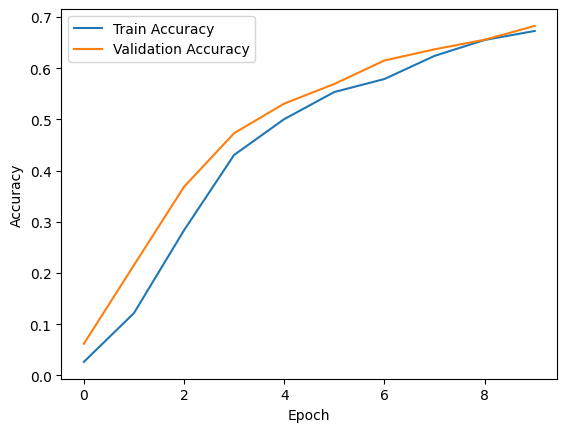

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

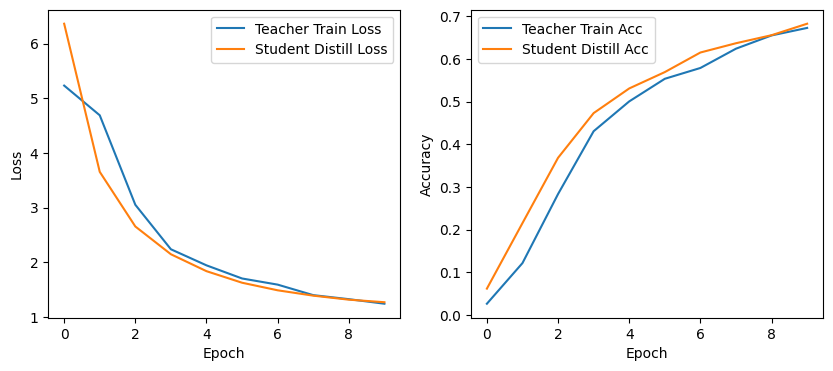

In [20]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Teacher Train Loss')
plt.plot(val_losses, label='Student Distill Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Teacher Train Acc')
plt.plot(val_accs, label='Student Distill Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()